In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer


In [ ]:
df = pd.read_csv("/Loan_Default.csv")

In [ ]:
df.Status.unique()

array([ 1.,  0., nan])

In [ ]:
df.drop(['ID','year','Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df_na = df.dropna(subset=['Status'])

In [ ]:
cat_vars = []
num_vars = []
for i in df_na.columns:
    if(df_na[i].dtype == "object"):
        cat_vars.append(i)
    else:
        num_vars.append(i)
print("Categorical Variables:\n",cat_vars,"\n")
print("Numerical Variables:\n",num_vars,"\n")

Categorical Variables:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type'] 

Numerical Variables:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1'] 



In [ ]:
df_num = df_na[num_vars]
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)

In [ ]:
df_num = pd.DataFrame(X, columns=num_vars)
df_num.isna().sum()

loan_amount             0
rate_of_interest        0
Interest_rate_spread    0
Upfront_charges         0
term                    0
property_value          0
income                  0
Credit_Score            0
LTV                     0
Status                  0
dtir1                   0
dtype: int64

In [ ]:
df_cat = df_na[cat_vars]
for i in cat_vars:
    mode = df_na[i].mode()
    mode = mode[0]
    df_cat[i].fillna(value=mode, inplace=True)

df_cat.isna().sum()

<ipython-input-168-13543a9f8834>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[i].fillna(value=mode, inplace=True)


loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: int64

In [ ]:
df_full = pd.concat([df_num, df_cat], axis=1, join='inner')
df_full.isna().sum()

loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
property_value               0
income                       0
Credit_Score                 0
LTV                          0
Status                       0
dtir1                        0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
credit_type                  0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
dtype: i

In [ ]:
df_full.to_csv('df_full.csv')

In [ ]:
'''
df_no_default = df_full.loc[(df_na['Status']==0)]
df_default = df_full.loc[(df_na['Status']==1)]

In [ ]:
'''
df_na.Status.unique()

array([1., 0.])

In [ ]:
'''
from sklearn.utils import resample

df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=6000, random_state=42 )
df_default_downsampled = resample(df_default, replace=False, n_samples=6000, random_state=42 )

In [ ]:
'''
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
len(df_downsample)

12000

In [ ]:
X = df_full.drop('Status', axis=1).copy()


In [ ]:
X.shape

(25487, 31)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder


ohe = OneHotEncoder(sparse_output=False, dtype="int")
ohe.fit(X[cat_vars])
X_ohe_train = ohe.transform(X[cat_vars])

X_ohe_train

array([[1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1]])

In [ ]:
with open('ohe.pkl', 'wb') as file:
    pickle.dump(ohe, file)

In [ ]:

transformed_ohe = pd.DataFrame(
    data=X_ohe_train,
    columns=ohe.get_feature_names_out(cat_vars),
    index=X.index,
)
transformed_ohe.head()

,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,loan_type_type1,loan_type_type2,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
1,1,0,0,0,1,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,1
2,1,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1
3,1,0,0,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
transformed_ohe.columns

Index(['loan_limit_cf', 'loan_limit_ncf', 'Gender_Female', 'Gender_Joint',
       'Gender_Male', 'Gender_Sex Not Available', 'approv_in_adv_nopre',
       'approv_in_adv_pre', 'loan_type_type1', 'loan_type_type2',
       'loan_type_type3', 'loan_purpose_p1', 'loan_purpose_p2',
       'loan_purpose_p3', 'loan_purpose_p4', 'Credit_Worthiness_l1',
       'Credit_Worthiness_l2', 'open_credit_nopc', 'open_credit_opc',
       'business_or_commercial_b/c', 'business_or_commercial_nob/c',
       'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg',
       'interest_only_int_only', 'interest_only_not_int',
       'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm',
       'construction_type_mh', 'construction_type_sb', 'occupancy_type_ir',
       'occupancy_type_pr', 'occupancy_type_sr', 'Secured_by_home',
       'Secured_by_land', 'total_units_1U', 'total_units_2U', 'total_units_3U',
       'total_units_4U', 'credit_type_CIB', 'credit_type_CRIF',
       'credit_type_EQUI', 'credit_type_EX

In [ ]:
X_encoded = pd.concat([X[['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1'] ], transformed_ohe], axis=1)
X_encoded.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,116500.0,3.791667,0.932600,2396.143333,360.0,118000.000000,1740.0,758.0,98.728814,45.000000,...,0,0,0,1,0,0,0,1,0,1
1,206500.0,3.371667,-0.354667,1023.686667,360.0,224666.666667,4980.0,552.0,92.071416,37.666667,...,0,0,0,1,1,0,0,0,0,1
2,406500.0,4.560000,0.200000,595.000000,360.0,508000.000000,9480.0,834.0,80.019685,46.000000,...,0,0,0,1,0,0,0,1,0,1
3,456500.0,4.250000,0.681000,956.460000,360.0,658000.000000,11880.0,587.0,69.376900,42.000000,...,0,0,1,0,1,0,0,0,0,1
4,696500.0,4.000000,0.304200,0.000000,360.0,758000.000000,10440.0,602.0,91.886544,39.000000,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
X_encoded .isna().sum()

loan_amount               0
rate_of_interest          0
Interest_rate_spread      0
Upfront_charges           0
term                      0
                         ..
Region_North-East         0
Region_central            0
Region_south              0
Security_Type_Indriect    0
Security_Type_direct      0
Length: 69, dtype: int64

In [ ]:
y = df_full['Status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

#scale the dat
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [ ]:
X.columns

Index(['loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score',
       'LTV', 'dtir1', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by',
       'total_units', 'credit_type', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'Region', 'Security_Type'],
      dtype='object')

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to y_train and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [ ]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

Accuracy: 88.62%


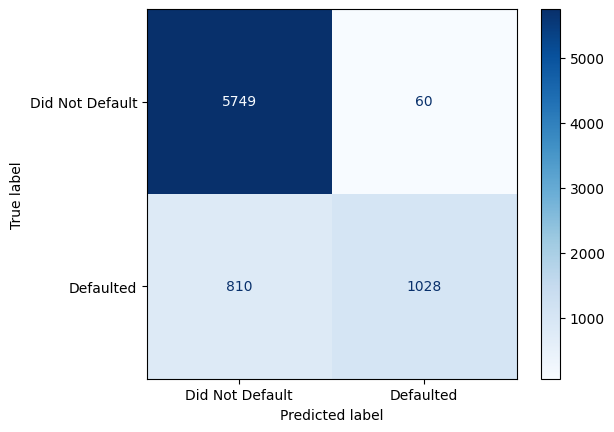

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt



clf_svm = SVC(random_state = 42) # you will get the same result everytime you run
clf_svm.fit(X_train_scaled, y_train_encoded)

#calculate overall accuracy
y_pred = clf_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.2%}')


class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
        clf_svm,
        X_test_scaled,
        y_test_encoded,
        display_labels=class_names,
        cmap=plt.cm.Blues)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming your data is in a pandas DataFrame called 'data'
categorical_features = ['color', 'size']  # Replace with actual column names
numerical_features = ['age', 'income']  # Replace with actual names

# Define transformers
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
numerical_transformer = StandardScaler()
imputer = Imputer(strategy='mean')  # Replace strategy as needed

# Combine transformers for different data types using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', categorical_transformer, categorical_features),
        ('scaler', numerical_transformer, numerical_features),
        ('imputer', imputer, ['missing_feature1', 'missing_feature2'])  # Replace with columns having missing values
    ]
)

# Add your model (e.g., LogisticRegression) to the pipeline
model = LogisticRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Train the pipeline on your data (X_train, y_train)
pipeline.fit(X_train, y_train)

# Make predictions on new data (X_test)
predictions = pipeline.predict(X_test)

['loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'property_value',
 'income',
 'Credit_Score',
 'LTV',
 'Status',
 'dtir1']

In [ ]:
import pickle

# Save the trained model to a file
with open('/datalab/model.pkl', 'wb') as file:
    pickle.dump(clf_svm, file)

In [ ]:
#prediction


In [ ]:
pre = df.loc[(df['Status']==0)]

In [ ]:
pre.drop(['Status'], axis=1, inplace=True)

<ipython-input-186-10360a6d26cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre.drop(['Status'], axis=1, inplace=True)


In [ ]:
pre

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,dtir1
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500.0,4.560,...,9480.0,EXP,834.0,CIB,35-44,to_inst,80.019685,south,direct,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500.0,4.250,...,11880.0,EXP,587.0,CIB,45-54,not_inst,69.376900,North,direct,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500.0,4.000,...,10440.0,CRIF,602.0,EXP,25-34,not_inst,91.886544,North,direct,39.0
5,cf,Joint,pre,type1,p1,l1,nopc,nob/c,706500.0,3.990,...,10080.0,EXP,864.0,EXP,35-44,not_inst,70.089286,North,direct,40.0
6,cf,Joint,pre,type1,p3,l1,nopc,nob/c,346500.0,4.500,...,5040.0,EXP,860.0,EXP,55-64,to_inst,79.109589,North,direct,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25479,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,616500.0,3.500,...,22920.0,CRIF,536.0,EXP,35-44,not_inst,74.456522,south,direct,31.0
25481,cf,Male,nopre,type1,p1,l1,nopc,nob/c,486500.0,3.875,...,6240.0,EXP,836.0,CIB,35-44,not_inst,92.140152,south,direct,45.0
25482,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,336500.0,3.375,...,8760.0,CIB,507.0,CIB,55-64,to_inst,63.731061,south,direct,37.0
25483,cf,Female,pre,type1,p1,l1,nopc,nob/c,306500.0,4.990,...,6000.0,CIB,539.0,EXP,55-64,to_inst,88.074713,North,direct,47.0


In [ ]:
pre.isna().sum()

loan_limit                    424
Gender                          0
approv_in_adv                 105
loan_type                       0
loan_purpose                   13
Credit_Worthiness               0
open_credit                     0
business_or_commercial          0
loan_amount                     0
rate_of_interest                0
Interest_rate_spread            0
Upfront_charges               525
term                            4
Neg_ammortization              12
interest_only                   0
lump_sum_payment                0
property_value                  0
construction_type               0
occupancy_type                  0
Secured_by                      0
total_units                     0
income                       1306
credit_type                     0
Credit_Score                    0
co-applicant_credit_type        0
age                             0
submission_of_application       0
LTV                             0
Region                          0
Security_Type 

In [ ]:
pre.dropna(inplace=True)

<ipython-input-189-82427ca23007>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre.dropna(inplace=True)


In [ ]:
pre.isna().sum()

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
dtir1                        0
dtype: int64

In [ ]:
pre.shape

(16959, 31)

In [ ]:
X_ohe_train = ohe.transform(pre[cat_vars])

X_ohe_train

array([[1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1]])

In [ ]:
transformed_ohe = pd.DataFrame(
    data=X_ohe_train,
    columns=ohe.get_feature_names_out(cat_vars),
    index=pre.index,
)
transformed_ohe.head()

,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,loan_type_type1,loan_type_type2,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
2,1,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1
4,1,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
5,1,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
6,1,0,0,1,0,0,0,1,1,0,...,0,0,0,1,1,0,0,0,0,1
8,1,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
p = pd.concat([pre[['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1'] ], transformed_ohe], axis=1)
p.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
2,406500.0,4.560,0.2000,595.0,360.0,508000.0,9480.0,834.0,80.019685,46.0,...,0,0,0,1,0,0,0,1,0,1
4,696500.0,4.000,0.3042,0.0,360.0,758000.0,10440.0,602.0,91.886544,39.0,...,0,0,1,0,1,0,0,0,0,1
5,706500.0,3.990,0.1523,370.0,360.0,1008000.0,10080.0,864.0,70.089286,40.0,...,0,0,1,0,1,0,0,0,0,1
6,346500.0,4.500,0.9998,5120.0,360.0,438000.0,5040.0,860.0,79.109589,44.0,...,0,0,0,1,1,0,0,0,0,1
8,376500.0,4.875,0.7395,1150.0,360.0,478000.0,5580.0,580.0,78.765690,44.0,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
test = scale(p)

In [ ]:
y = pd.DataFrame(clf_svm.predict(test))

In [ ]:
y.value_counts()

0    16710
1      249
Name: count, dtype: int64